In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import stan
import arviz as az # For visualization and loo
#needed for notebook
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_v3_utility

In [3]:
# edit default plot settings
plt.rc('font', size=12)
az.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [7.0, 5.4]

/tmp/ipykernel_652/1626268779.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  az.style.use('seaborn-darkgrid')


### Decision analysis for the factory data (3p)

This exercise is an example of a decision analysis (DA). In a broad context, this means optimizing over different decisions that lead to different outcomes that all have different utilities. In a Bayesian context, this means using posterior distributions to make decisions. In this exercise, you work as a data analyst in the company that owns the six machines that have produced the data in the factory dataset. To access the data, just use: 

library(aaltobda) 
data("factory") 

Your task is to decide whether or not to buy a new (7th) machine for the company. The decision should be based on our best knowledge about the machines.

The following is known about the production process: 

• The given data contains quality measurements of single products from the six machines that are ordered from the same seller. (columns: different machines, rows: measurements) 

• Customers pay 200 euros for each product.

        – If the quality of the product is below 85, the product cannot be sold 
        
        – All the products that have sufficient quality are sold.

• Raw-materials, the salary of the machine user and the usage cost of the machine for each product cost 106 euros in total.

        – Usage cost of the machine also involves all investment and repair costs divided by the number of products a machine can create. So there is no need to take the investment cost into account as a separate factor.
        
• The only thing the company owner cares about is money. Thus, as a utility function, use the profit of a new product from a machine.

As noticed in the previous assignment, the hierarchical model fits best with the dataset, so use it to compute the utilities. The assumptions for the hierarchical model are the same as in assignment 7 and 8. If you did things correctly then, solving the assignment only requires you to change the "generated quantities"-block in the Stan-code to compute the correct predictive samples for products of all 7 (= 6 + 1) machines.

Your task is the following:

    1. For each of the six machines, compute and report the expected utility of one product of that machine. Below is a test case on how the utility function should work (and that you can test with markmyassignment. 
    
    Note! The expected utility should be computed from the quality measurements of the products of each machine, not from the means of the qualities of each machine.
    
    Note! This is just a test case to test that your utility function works. In the report, you should report the expected utility using your posterior draws from Stan. 
    
    Note! The value below is only a test case, you need to use correct draws from the predictive distribution in the final report.

y_pred <- c(123.80, 85.23, 70.16, 80.57, 84.91) 

utility(draws = y_pred) 

[1] -26

In [41]:
examples=[123.80, 85.23, 70.16, 80.57, 84.91]
revenue=(np.array(examples)>=85).sum()*200
costs=len(examples)*106
np.sum(revenue-costs)/len(examples)

-26.0

In [40]:
(np.array(examples)>=85).sum()

2

In [5]:
#data
df_factory=pd.read_table('data/factory.txt',sep=' ', names=['V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
df_factory

,V1,V2,V3,V4,V5,V6
0,83,117,101,105,79,57
1,92,109,93,119,97,92
2,92,114,92,116,103,104
3,46,104,86,102,79,77
4,67,87,67,116,92,100


In [6]:
data_factory={'y':df_factory.values.tolist(),
             'N':df_factory.shape[0],
             'J':df_factory.shape[1]}

In [7]:
hierarhical_model="""
data {
    int<lower=0> N; 
    int<lower=0> J; 
    vector[J] y[N]; 
    } 
    
parameters { 
    vector[J] mu;
    real<lower=0> sigma;
    real alpha;
    real<lower=0> tau;
    }
    
model {
     // hyperpriors
      alpha ~ normal(100, 10);
      tau ~ normal(0, 10);
      // priors
      mu ~ normal(alpha, tau);
      sigma ~ inv_chi_square(5); 
     
     // likelihood
      for (j in 1:J) {
              y[,j] ~ normal(mu[j], sigma);
          }
     } 
  
generated quantities { 
    // Compute the predictive distribution for the sixth machine.
      real y6pred;  // Leave for compatibility with earlier assignments.
      vector[J] ypred;
      real mu7pred;
      real y7pred;
      vector[J] log_lik[N];

      y6pred = normal_rng(mu[6], sigma);
      for (j in 1:J) {
        ypred[j] = normal_rng(mu[j], sigma);
      }

      mu7pred = normal_rng(alpha, tau);
      y7pred = normal_rng(mu7pred, sigma);

      for (j in 1:J) {
        for (n in 1:N) {
          log_lik[n,j] = normal_lpdf(y[n,j] | mu[j], sigma);
        }
      }
  }
"""

In [8]:
model_f_hierach=stan.build(program_code=hierarhical_model, data=data_factory, random_seed=234)

Building: 0.1s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jovyan/.cache/httpstan/4.9.1/models/j4dg3v27/model_j4dg3v27.cpp:2:
/opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(c

Building: 8.2s
Building: 8.3s
Building: 8.4s


/home/jovyan/.cache/httpstan/4.9.1/models/j4dg3v27/model_j4dg3v27.cpp: In instantiation of ‘void model_j4dg3v27_namespace::model_j4dg3v27::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jovyan/.cache/httpstan/4.9.1/models/j4dg3v27/model_j4dg3v27.cpp:559:26:   required from here
/home/jovyan/.cache/httpstan/4.9.1/models/j4dg3v27/model_j4dg3v27.cpp:335:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  335 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /opt/conda/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:

Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Buildin

Building: 16.0s, done.
Messages from stanc:
Warning in '/tmp/httpstan_x4n2gmxg/model_j4dg3v27.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_x4n2gmxg/model_j4dg3v27.stan', line 35, column 6: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_x4n2gmxg/model_j4dg3v27.stan', line 17, column 21: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [10]:
fit_f_hierarch = model_f_hierach.sample()

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [11]:
df_fit_hierarch=fit_f_hierarch.to_frame()
df_fit_hierarch.shape

(4000, 55)

In [12]:
df_fit_hierarch

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,log_lik.1.5,log_lik.2.5,log_lik.3.5,log_lik.4.5,log_lik.5.5,log_lik.1.6,log_lik.2.6,log_lik.3.6,log_lik.4.6,log_lik.5.6
draws,,,,,,,,,,,,,,,,,,,,,
0,-117.259674,1.000000,0.450403,2.0,3.0,0.0,119.874938,95.409618,94.957747,94.174916,...,-4.075486,-3.918028,-4.061367,-4.075486,-3.873373,-5.579167,-3.872784,-4.054721,-4.196122,-3.950558
1,-117.589973,0.842476,0.484985,3.0,7.0,0.0,123.752138,73.424132,101.863286,80.507307,...,-3.800104,-3.882643,-4.200644,-3.800104,-3.728592,-5.146468,-3.804324,-4.481906,-3.774345,-4.191493
2,-114.502412,0.931969,0.450675,3.0,7.0,0.0,116.273444,79.115267,107.991778,90.731184,...,-3.778488,-3.664679,-4.061556,-3.778488,-3.500023,-6.240976,-3.541158,-4.318525,-3.792362,-3.962778
3,-117.142414,0.970629,0.477315,3.0,7.0,0.0,120.401089,77.807227,104.035135,90.045176,...,-4.063161,-3.671586,-3.855029,-4.063161,-3.638635,-6.681517,-3.648759,-3.838665,-4.294413,-3.705592
4,-116.852270,0.651004,0.450403,3.0,7.0,0.0,122.882121,93.066162,102.839154,97.361918,...,-4.546243,-3.707659,-3.709652,-4.546243,-3.813524,-6.882813,-3.748173,-3.776062,-4.505089,-3.704205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-117.554822,0.980612,0.477315,3.0,7.0,0.0,121.499842,78.608196,110.426824,81.959725,...,-3.622707,-3.676981,-4.298360,-3.622707,-3.389587,-7.246471,-3.389113,-4.429469,-3.785416,-3.948620
3996,-118.430594,0.905689,0.450403,3.0,7.0,0.0,120.582409,91.460042,102.632045,88.610807,...,-5.072526,-3.761341,-3.639802,-5.072526,-3.983136,-6.150830,-3.636727,-4.010545,-4.056862,-3.815823
3997,-123.017987,0.904618,0.484985,3.0,7.0,0.0,127.523684,79.173285,105.441457,83.993570,...,-4.257351,-3.654163,-3.757666,-4.257351,-3.684237,-4.010299,-4.673439,-6.093687,-3.754723,-5.552590


In [15]:
az.summary(fit_f_hierarch)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],81.639,6.456,71.168,96.300,0.317,0.240,485.0,102.0,1.01
mu[1],102.623,5.869,91.863,113.639,0.104,0.074,3164.0,2665.0,1.00
mu[2],89.874,5.530,80.087,100.299,0.131,0.096,1778.0,1502.0,1.00
mu[3],106.346,6.273,94.845,117.975,0.145,0.102,1942.0,2626.0,1.00
mu[4],91.323,5.614,81.057,102.623,0.126,0.091,1932.0,2862.0,1.00
mu[5],88.682,5.818,77.931,99.452,0.146,0.107,1492.0,1679.0,1.00
sigma,14.329,2.071,10.753,18.251,0.045,0.033,2249.0,2188.0,1.00
alpha,94.586,4.666,85.707,103.170,0.081,0.057,3353.0,3168.0,1.00
tau,11.006,4.201,3.826,19.824,0.184,0.130,400.0,84.0,1.01
y6pred,89.358,16.044,57.571,117.983,0.253,0.179,3999.0,3929.0,1.00


In [45]:
columns=['mu.1', 'mu.2','mu.3','mu.4','mu.5', 'mu.6', 'mu7pred']
cost=106
price=200
results={}
for col in columns:
    costs=np.array([cost]*len(df_fit_hierarch[col]))
    revenues=np.where(df_fit_hierarch[col]>=85, price, 0)
    profit_loss=revenues-costs
    results[col]=profit_loss

<Axes: >

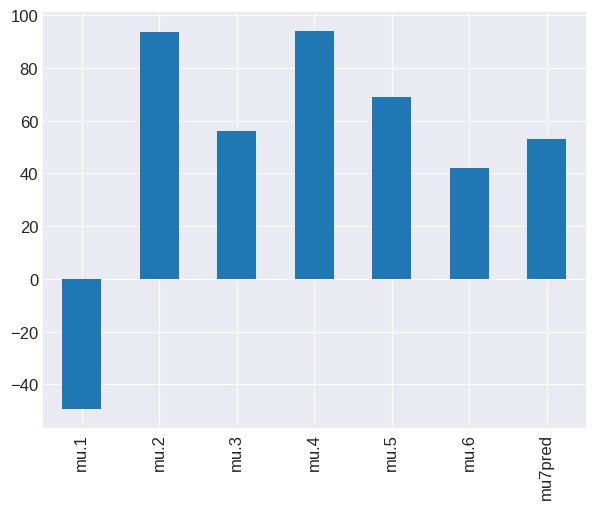

In [46]:
pd.DataFrame(results).mean(axis=0).plot(kind='bar')

2. Rank the machines based on the expected utilities. In other words order the machines from worst to best: X(worst), X, X, X, X, X(best), where each X should be a number of a machine. Also briefly explain what the utility values tell about the quality of these machines. E.g. Tell which machines are profitable and which are not (if any).

3. Compute and report the expected utility of the products of a new (7th) machine.

4. Based on your analysis, discuss briefly whether the company owner should buy a new (7th) machine.

5. As usual, remember to include the source code for both Stan and R (or Python).